# Simple Neural Net From Scratch

## The Fundamental Idea
- In our body, neurons form the smallest unit of the brain
- Each individual neuron is a pretty simple structure, it takes a few inputs (we represent them in a vector), modifies them (we represent these as multiplication by a weight and addition to a bias), and then sends the output forward
- Such simple neurons arranged in very complex ways enable our brain to solve problems and identify patterns and what not
- So the power of a neural network similarly will come from complex connections between simple units called neurons 

## Linear Unit
- An individual neuron performs the following
- $y = wx + b$
- Here - 
1. x is the input
2. w is the weight, the strength of the connection of this input to this neuron
3. b is the bias
4. y is the output

## With Multiple Inputs
- Each new input gets a new weight associated with it
- $y = w_0x_0 + w_1x_1 + w_2x_2 ... + w_{n-1}x_{n-1} + b$

## Now Multiple Neurons
- One Neuron on its own is not that useful, so we make a lot of them, all acting on the same set of inputs - $x_0$ through $x_{n-1}$
- Each set of such neurons is called a layer

## Multiple Layers
- Each layer is a rather simple transformation on a vector, but a stack of layers can handle a lot more complexity
- However, if two layers are connected linearly, they are always going to be equivalent to one layer
- To introduce non-linearity in this system, we connect layers with specialised functions called activation functions

### Activation Function
- These allow our layers to learn non-linear data
- There are a few different types - tanh, sigmoid, ReLu, Leaky ReLu, softmax, etc.
- But the basic purpose is the same, it can take a linear output of one layer and map it non-linearly before sending it as input to the next layer, thus introducing the non-linearity we want

#### Dense Layers
- A layer in which all the neurons take input from all the neurons of a previous layer

#### Fully Connected Network 
- Network where all neurons of one layer connect to all neurons of the next layer

## Make it capable of learning
- While our network as it is now is capable of producing an output, it isn't capable of learning
- This is called forward propagation - the flow of data from one layer to the next, till it produces an output at the end
- But learning involves adjusting from mistakes, and we need a way to incorporate this

## Mistakes - Loss Function
- A Loss Function takes in the actual output the model was supposed to give, and the output the model predicted, and gives some value that can tell us how wrong the model was
- Usually this is done by finding the mean square error.

## Learning from a Mistake
- Each weight and bias contributes to the final error value, and technically there must be an ideal value of weights and biases for which the model produces the correct output
- Finding the correct value of a parameter using errors is accomplished by derivatives. We find the derivative of the error with respect to each parameter. Change the value of the parameter in steps to minimize the error.
- Eventually the parameters will reach their ideal value, depending on how big the steps are.
- This is called backward propagation.
- The learning rate is the special parameter that decides the size of the steps

The basic flow of a neural net is explained thusly - 
1. Feed input into the network
2. Forward Propagation - Data flows from layer to layer till you get an output
3. From the output, we can find a scalar error
4. Backward Propagation - Differentiate the scalar error with respect to each parameter and adjust it
5. Iterate again and again till error is minimized

# Implementation

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

The way I intend to approach this network is by defining simple template classes and then defining superclasses on them to make my final model

## Basic Layer Template

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def for_prop(self,input):
        raise NotImplementedError
    
    def back_prop(self,output_error,learning_rate):
        raise NotImplementedError

## Fully Connceted Layer Template

In [3]:
# Define Fully Connected Layer
class FullCon_Layer(Layer):
    def __init__(self,i_size,o_size):
        self.weights = np.random.rand(i_size,o_size) - 0.5
        self.bias = np.random.rand(1,o_size) - 0.5

    def for_prop(self, i_data):
        self.input = i_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def back_prop(self, o_error, learning_rate):
        i_error = np.dot(o_error, self.weights.T)
        weights_error = np.dot(self.input.T, o_error)

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * o_error
        return i_error


## Activation Layer Template

In [4]:
# Define Activation Layers
class Activ_Layer(Layer):
    def __init__(self, activ,activ_dash):
        self.activation = activ
        self.activation_dash = activ_dash
    
    def for_prop(self, i_data):
        self.input = i_data
        self.output = self.activation(self.input)
        return self.output
    
    def back_prop(self, o_error, learning_rate):
        return self.activation_dash(self.input) * o_error

### Some specific activation functions

In [5]:
# Define some activation functions
def tanh(x):
    return np.tanh(x)

def tanh_dash(x):
    return 1-np.tanh(x)**2

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_dash(x):
    return sigmoid(x)*(1-sigmoid(x))

## Loss Function Definition

In [6]:
# Define Loss Functions
def mean_sq_error(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred,2))

def deriv_error(y_true,y_pred):
    return 2*(y_pred-y_true)/y_true.size

## Network Template

In [7]:
# Define Network Template
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_dash = None
    
    def add_layer(self,layer):
        self.layers.append(layer)
    
    def use_func(self,loss,loss_dash):
        self.loss = loss
        self.loss_dash = loss_dash
    
    def predict(self,i_data):
        result = []
        for i in i_data:
            output = i
            for layer in self.layers:
                output = layer.for_prop(output)
            result.append(output)
        
        return result
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train)
        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.for_prop(output)

                err += self.loss(y_train[j], output)

                error = self.loss_dash(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.back_prop(error, learning_rate)

            err /= samples
            print(f'epoch {i+1}/{epochs}: error={err}')

# Testing the Model on MNIST dataset

In [12]:
# MNIST
from keras.datasets import mnist
from keras.utils import np_utils
# load data
(x_train,y_train),(_x_test,_y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_test = _x_test.reshape(_x_test.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Convert 0-255 pixel intensity values to 0-1 range
x_train /= 255
x_test /= 255

# The output is 0 - 9, however we will store it as an array of 10 boolean values instead
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(_y_test)

Model = Network()
Model.add_layer(FullCon_Layer(28*28,100))                 # Input
Model.add_layer(Activ_Layer(tanh,tanh_dash))
Model.add_layer(FullCon_Layer(100,50))
Model.add_layer(Activ_Layer(sigmoid,sigmoid_dash))
Model.add_layer(FullCon_Layer(50,10))
Model.add_layer(Activ_Layer(sigmoid,sigmoid_dash))

Model.use_func(mean_sq_error,deriv_error)
Model.fit(x_train[0:1000],y_train[0:1000],epochs=40,learning_rate=0.1)


epoch 1/40: error=0.09510017248606442
epoch 2/40: error=0.07528109867367527
epoch 3/40: error=0.06300385284568627
epoch 4/40: error=0.05281841538954699
epoch 5/40: error=0.045320136470309955
epoch 6/40: error=0.03980616915025925
epoch 7/40: error=0.035537480298379345
epoch 8/40: error=0.03207767616291494
epoch 9/40: error=0.029183010889167672
epoch 10/40: error=0.026707043729420354
epoch 11/40: error=0.024555029690879582
epoch 12/40: error=0.022662380875471417
epoch 13/40: error=0.02098443104635006
epoch 14/40: error=0.019490502779520368
epoch 15/40: error=0.018155128843872898
epoch 16/40: error=0.016954627782864343
epoch 17/40: error=0.015868691876561293
epoch 18/40: error=0.014880867747338187
epoch 19/40: error=0.013978143927683937
epoch 20/40: error=0.013150199098016936
epoch 21/40: error=0.012388525506674804
epoch 22/40: error=0.01168572928449675
epoch 23/40: error=0.011035190935115067
epoch 24/40: error=0.010431072517388505
epoch 25/40: error=0.009868544057884844
epoch 26/40: erro

8    6    6    5    9    3    1    8    0    1    

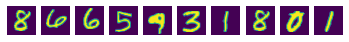

Predicted value: 
8    2    6    3    9    3    1    8    0    1    

In [14]:
n = 10   # = no. of images to see predictions on

index = np.random.choice(10000,size=n)

for i,ind in enumerate(index):
    plt.subplot(1,n,i+1)
    plt.imshow(_x_test[ind])
    plt.axis("off")
    print(np.argmax(y_test[ind]*255),end="    ")

plt.show()
print("Predicted value: ")
for i,ind in enumerate(index):
    predict = Model.predict(np.array([x_test[ind]]))[0]
    digit = np.argmax(predict)
    print(digit,end="    ")

These values are reasonably correct, except in complex cases, which is to be expected as this is a very simple model